# ALGOTHON 2021 - IMPERIAL COLLEGE LONDON 
By *Daniel Plaza Herrera* and *Jonathan Sanz Carcelen*
# CHALLENGE 2: Machine Learning Strategy Challenge

## Import libraries

In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import scipy.stats
from scipy.stats import norm
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Arima
from statsmodels.tsa.arima_model import ARIMA

## for machine learning
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.cluster import *
from sklearn.preprocessing import *
from sklearn.pipeline import *

from scipy.cluster.hierarchy import *

from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import KNeighborsClassifier as KNN

from datetime import datetime

from pprint import pprint as pp

pd.options.mode.chained_assignment = None 

import warnings
warnings.filterwarnings("ignore")

## Challenge goals
Aspect will provide a list of trades generated from a real production trading strategy, each trade has 3 fields: market / time-on / time-off (market is anonymised) and the pnl for each trade.

The challenge is to use all available market information prior to the trade to forecast the profitability of the trade.

**Goal**: Build a predictive model for each trade and return action.

Each model should predict the return of each trade and return an action (-1,0,1)
- 1 means implement the trade
- 0 means do nothing
- -1 means implement the opposite of the trade

Models can also assign a weight between -1 to 1 as a portfolio holding instead.

## Loading the dataset and processing the datetime values

In [2]:
df = pd.read_csv('ml_train.csv')
df['date'] = df['Trade_date'] + ' ' + df['Trade_time']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['date'] = df['date'].dt.date

df = df.drop(['Trade_date', 'Trade_time'], axis=1)
df.insert(0, 'date', df.pop('date'))

df = df.rename(columns={'Market': 'market', 'Return':'return'})

df = df.set_index('date')
df = df.sort_values('date')

df.head()

,market,return
date,,
2006-01-04,currency_1,-0.092167
2006-01-05,commodity_2,0.022351
2006-01-06,commodity_2,0.436682
2006-01-06,currency_2,0.374634
2006-01-06,commodity_1,-0.022852


## Preliminar assessment for a single market: currency_1

### Filling time gaps

In [3]:
i = 0
for market in df['market'].unique():
    df_market = df[df['market'] == market]

    df_date = pd.DataFrame(pd.date_range(start=min(df_market.index), end=max(df_market.index)), columns=['date'])
    df_date = df_date.set_index('date')
    df_date = df_date.join(df_market)
    df_date['market'] = df_date['market'].fillna(market)
    df_date['return'] = df_date['return'].interpolate()

    df_date['label'] = df_date['return'].apply(lambda l: -1 if l < 0 else (1 if l > 0 else 0))
    if i == 0:
        df_date_final = df_date
    else:
        df_date_final = pd.concat([df_date_final, df_date])
    i += 1

pp('markets: ')
pp(df_date_final['market'].unique())
df_date_final.head()

'markets: '
array(['currency_1', 'commodity_2', 'currency_2', 'commodity_1', 'bond_2',
       'stock_2', 'stock_1', 'bond_1'], dtype=object)


,market,return,label
date,,,
2006-01-04,currency_1,-0.092167,-1
2006-01-05,currency_1,-0.118689,-1
2006-01-06,currency_1,-0.145212,-1
2006-01-07,currency_1,-0.171734,-1
2006-01-08,currency_1,-0.198256,-1


### Train, validation and test datasets

In [4]:
df_train = df_date_final[df_date_final.index.year < 2012]
df_test = df_date_final[df_date_final.index.year >= 2012]

pp('Length of df_train: ' + str(len(df_train)))
pp('Length of df_test: ' + str(len(df_test)))

'Length of df_train: 13820'
'Length of df_test: 11346'


# ARIMA model
Meaning:
- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

ARIMA(p,d,q) parameters:
- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

## Assessment of stationarity property through the Augmented Dickey Fuller test 
Implementerd as adfuller(), from the statsmodels package.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'AutoRegressive%20Integrated,to%20predict%20the%20future%20values.

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train['return'].dropna())
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('as p-value < significance level (0.05) -> reject the null hypothesis -> time-series is stationary')

ADF Statistic: -20.794
p-value: 0.000
as p-value < significance level (0.05) -> reject the null hypothesis -> time-series is stationary


Since the series is stationary, differencing is not needed and **d** = 0

## Correlation between differences

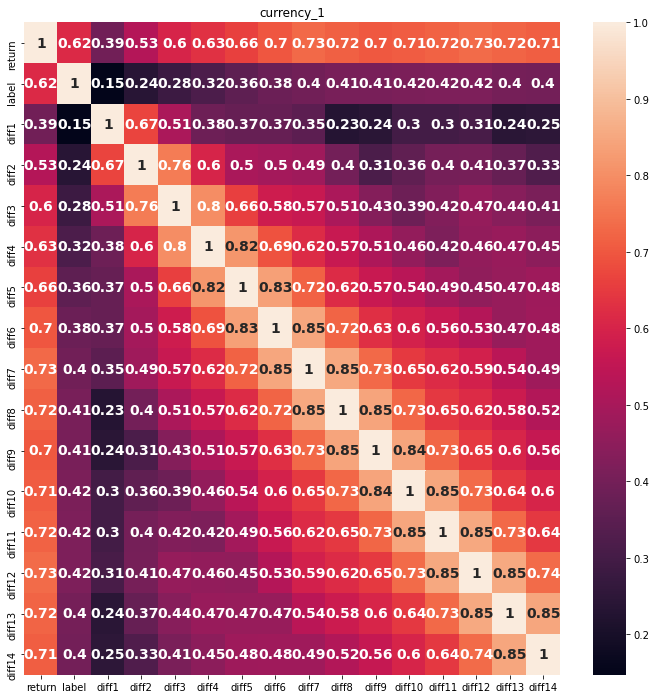

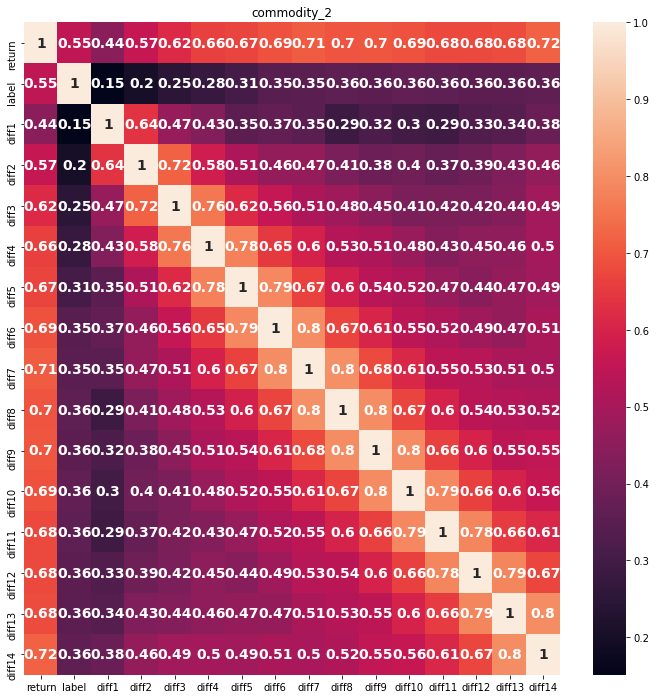

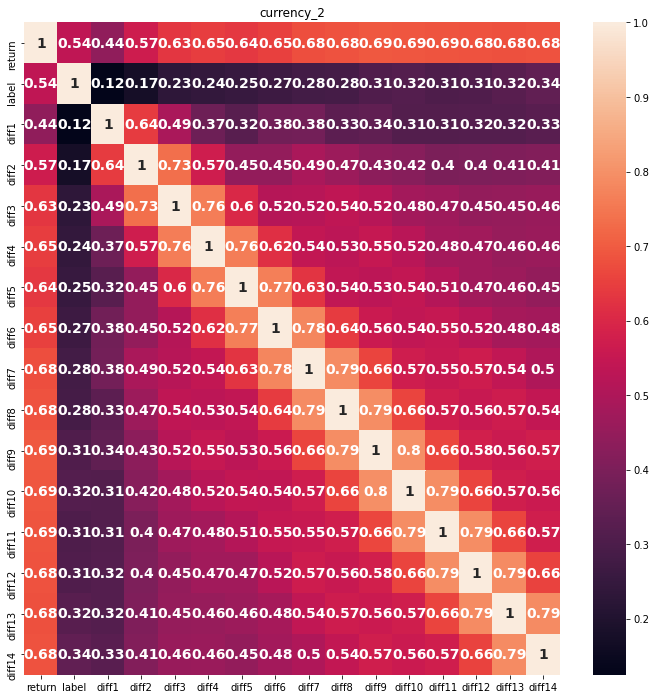

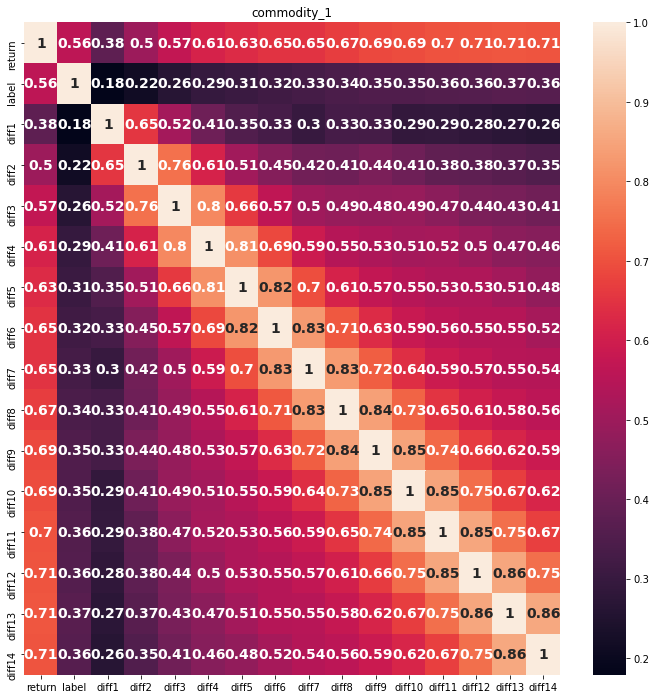

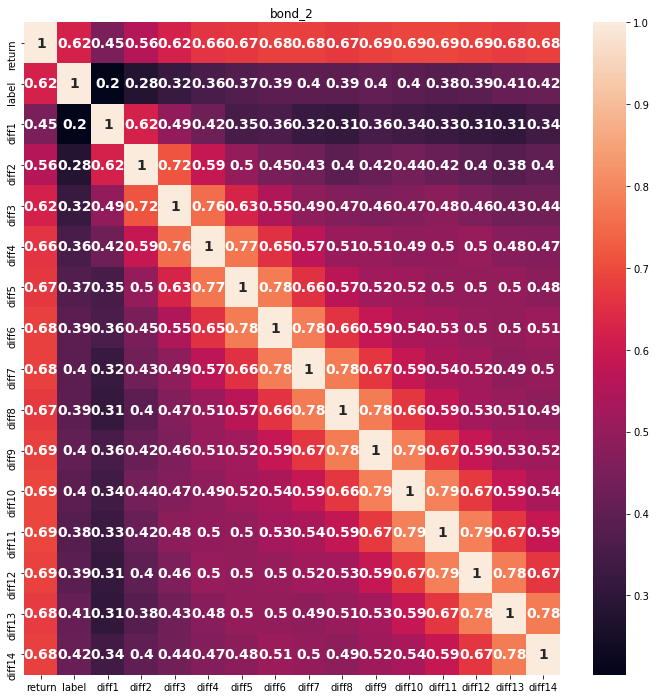

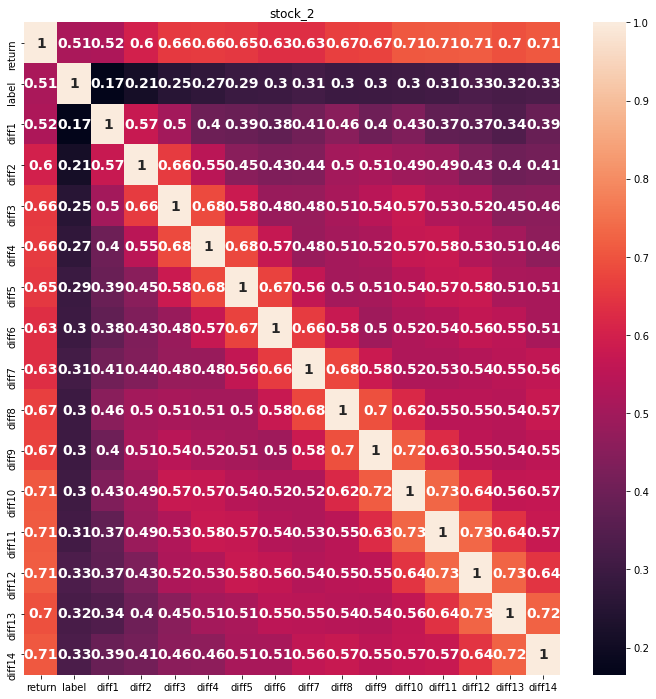

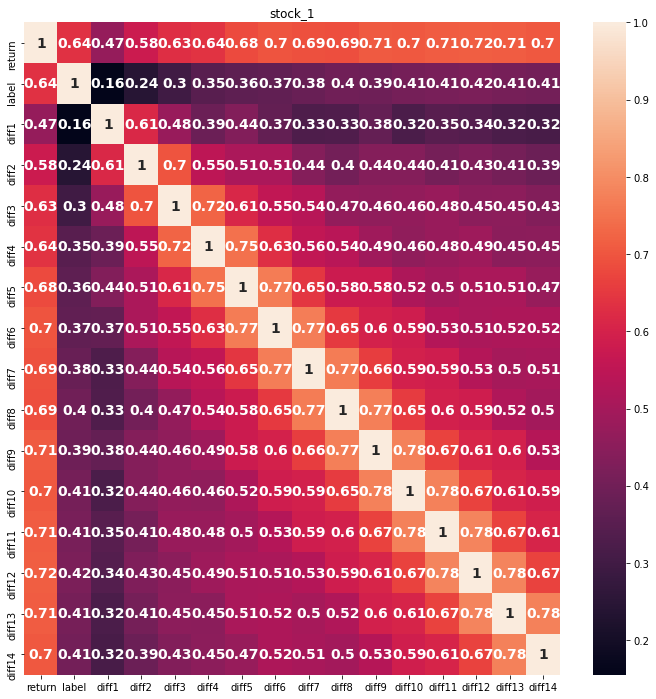

In [6]:
for market in df_train['market'].unique():
    df_aux = df_train[df_train['market'] == market]
    for i in range(1,15):
        df_aux['diff' + str(i)] = df_aux['return'] - df_aux['return'].shift(-i)
    
    corr_matrix = df_aux.corr()

    f0 = plt.figure(figsize=(12,12))
    sns.heatmap(corr_matrix, annot=True, annot_kws={'fontweight': 'bold', 'fontsize': 14})
    plt.title(market)
    plt.show()

## PACF plot of 1st differenced series
The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself. 

It is used to determine parameter q (size of moving average window). 

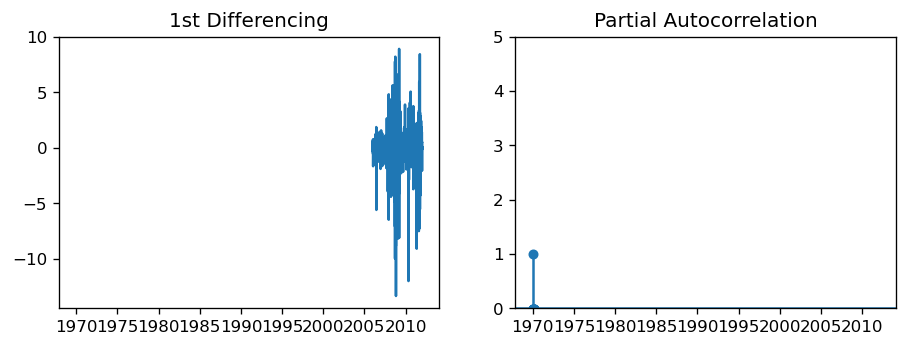

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_train['return'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_train['return'].diff().dropna(), ax=axes[1])

plt.show()

Conclusion: meaningful moving average window of **q** = 2

## Arima model

currency_1
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2188
Model:                     ARMA(5, 2)   Log Likelihood               -2059.959
Method:                       css-mle   S.D. of innovations              0.620
Date:                Sun, 28 Mar 2021   AIC                           4137.917
Time:                        14:10:07   BIC                           4189.134
Sample:                    01-04-2006   HQIC                          4156.638
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1044      0.040      2.600      0.009       0.026       0.183
ar.L1.return     1.2092      0.031     38.952      0.000       1.148       1.270
ar.L2.return    -1.2292      0.07

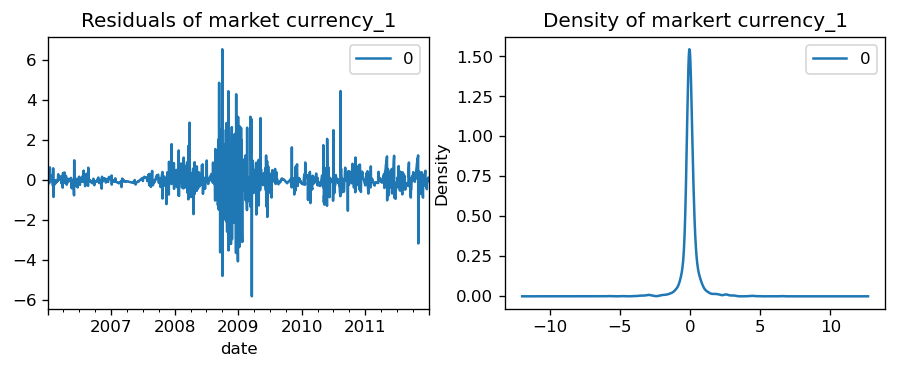

'Accuracy of ARIMA market currency_1: 0.5817932922655715'


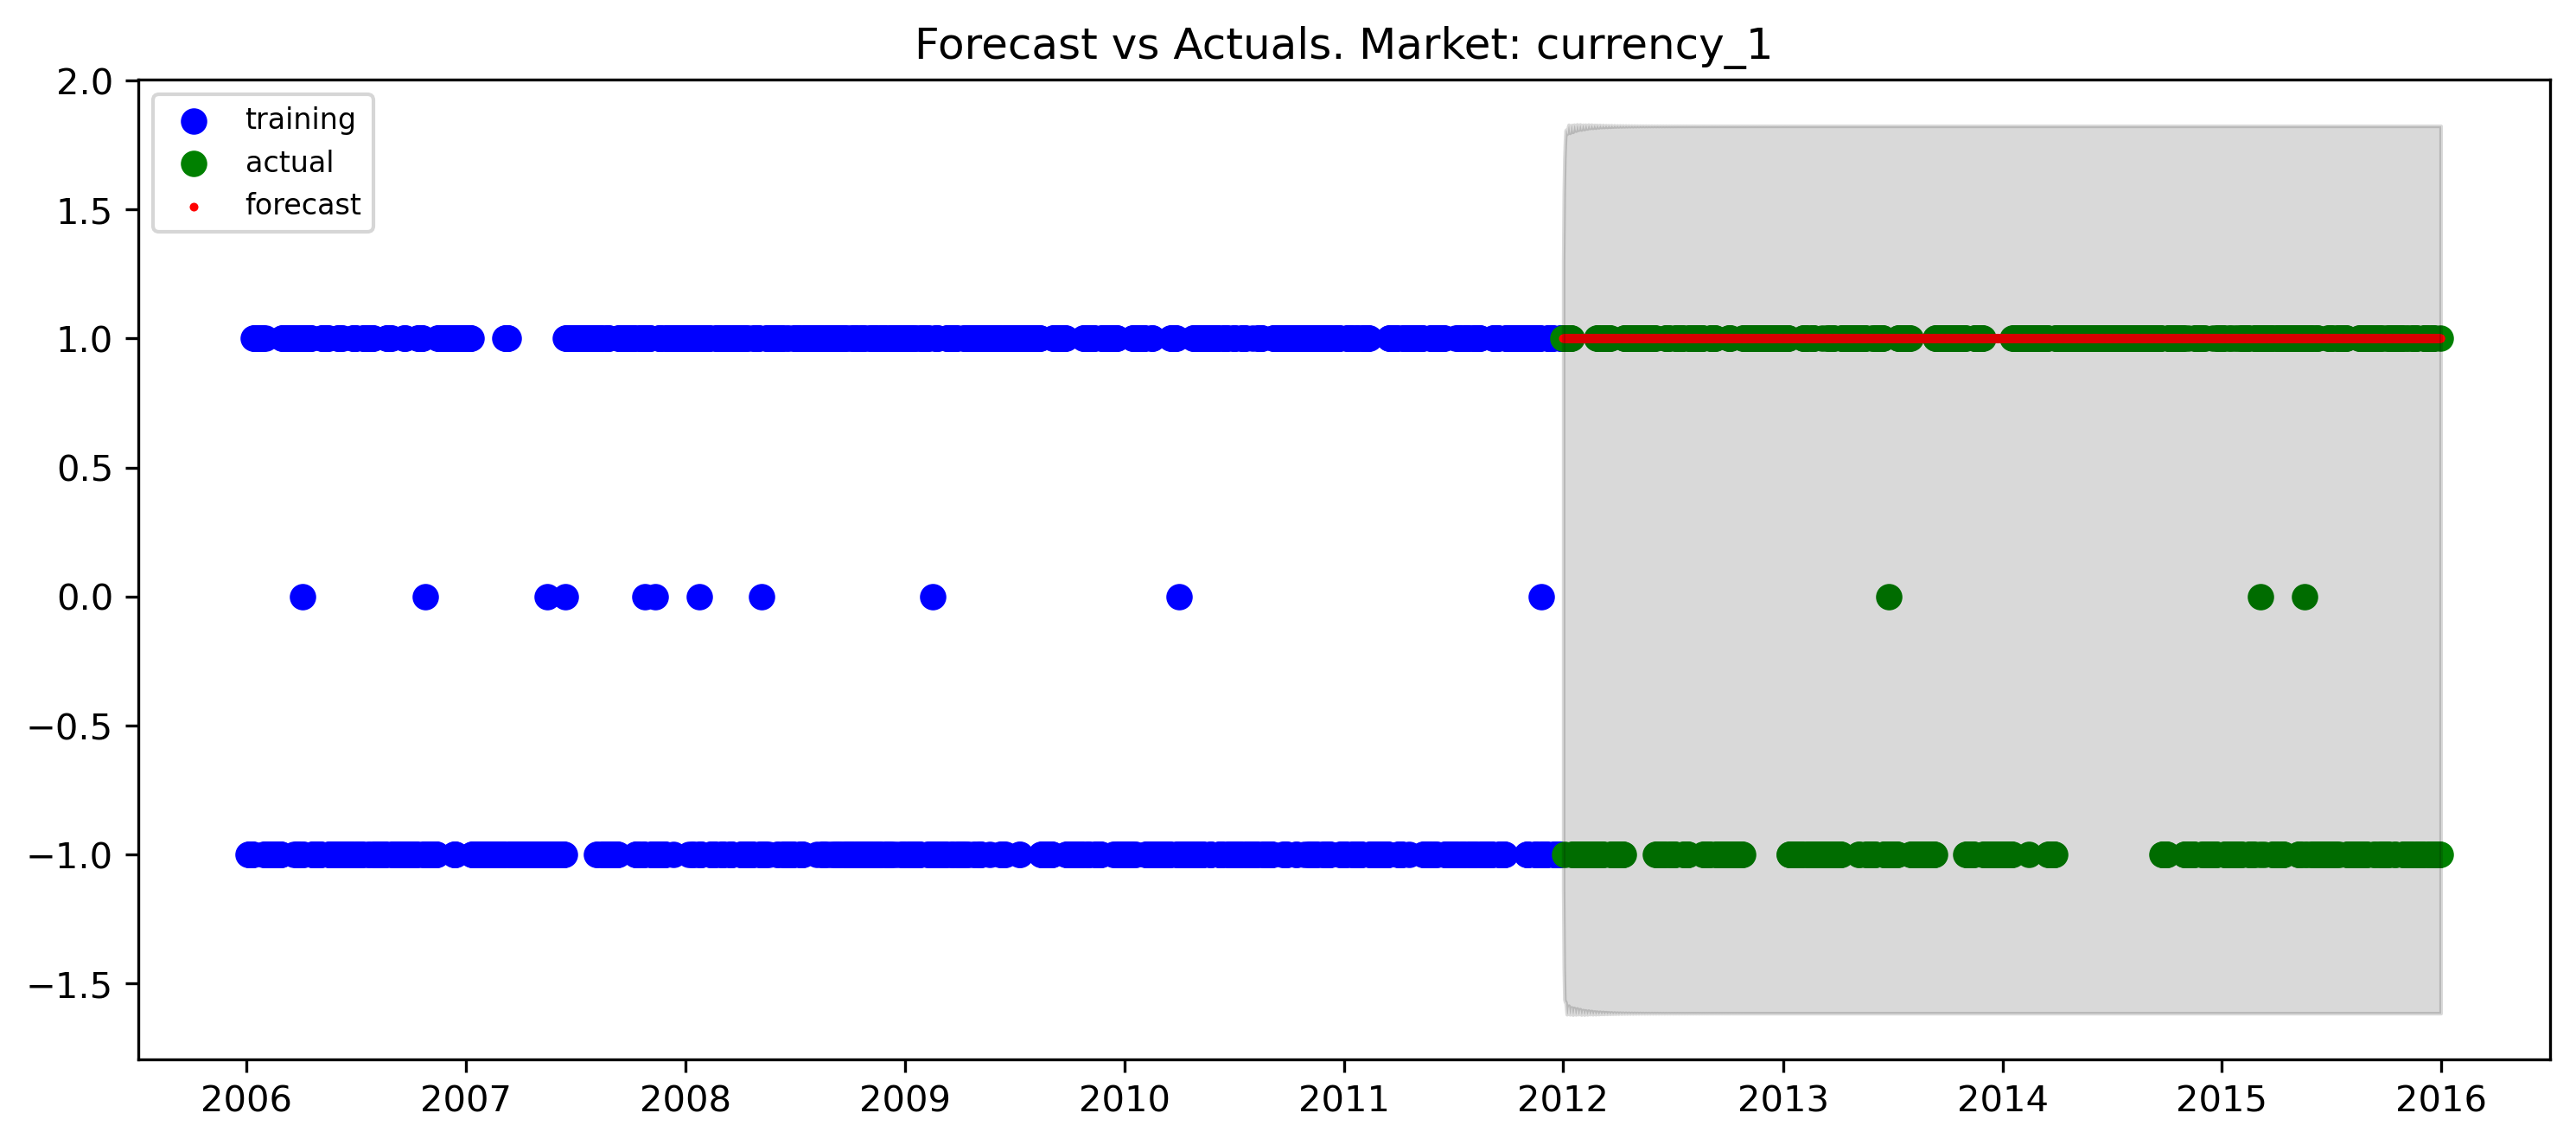

commodity_2
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2187
Model:                     ARMA(5, 2)   Log Likelihood               -1738.020
Method:                       css-mle   S.D. of innovations              0.536
Date:                Sun, 28 Mar 2021   AIC                           3494.039
Time:                        14:10:10   BIC                           3545.252
Sample:                    01-05-2006   HQIC                          3512.759
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1285      0.029      4.387      0.000       0.071       0.186
ar.L1.return    -0.9618      0.037    -26.196      0.000      -1.034      -0.890
ar.L2.return     0.0246      0.0

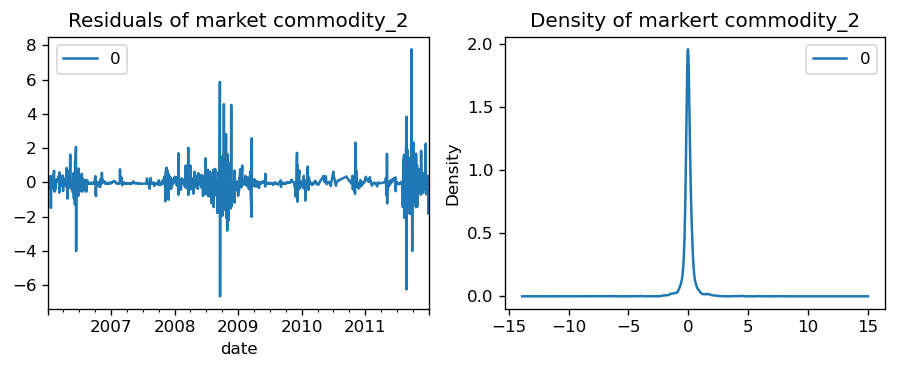

'Accuracy of ARIMA market commodity_2: 0.5589248793935218'


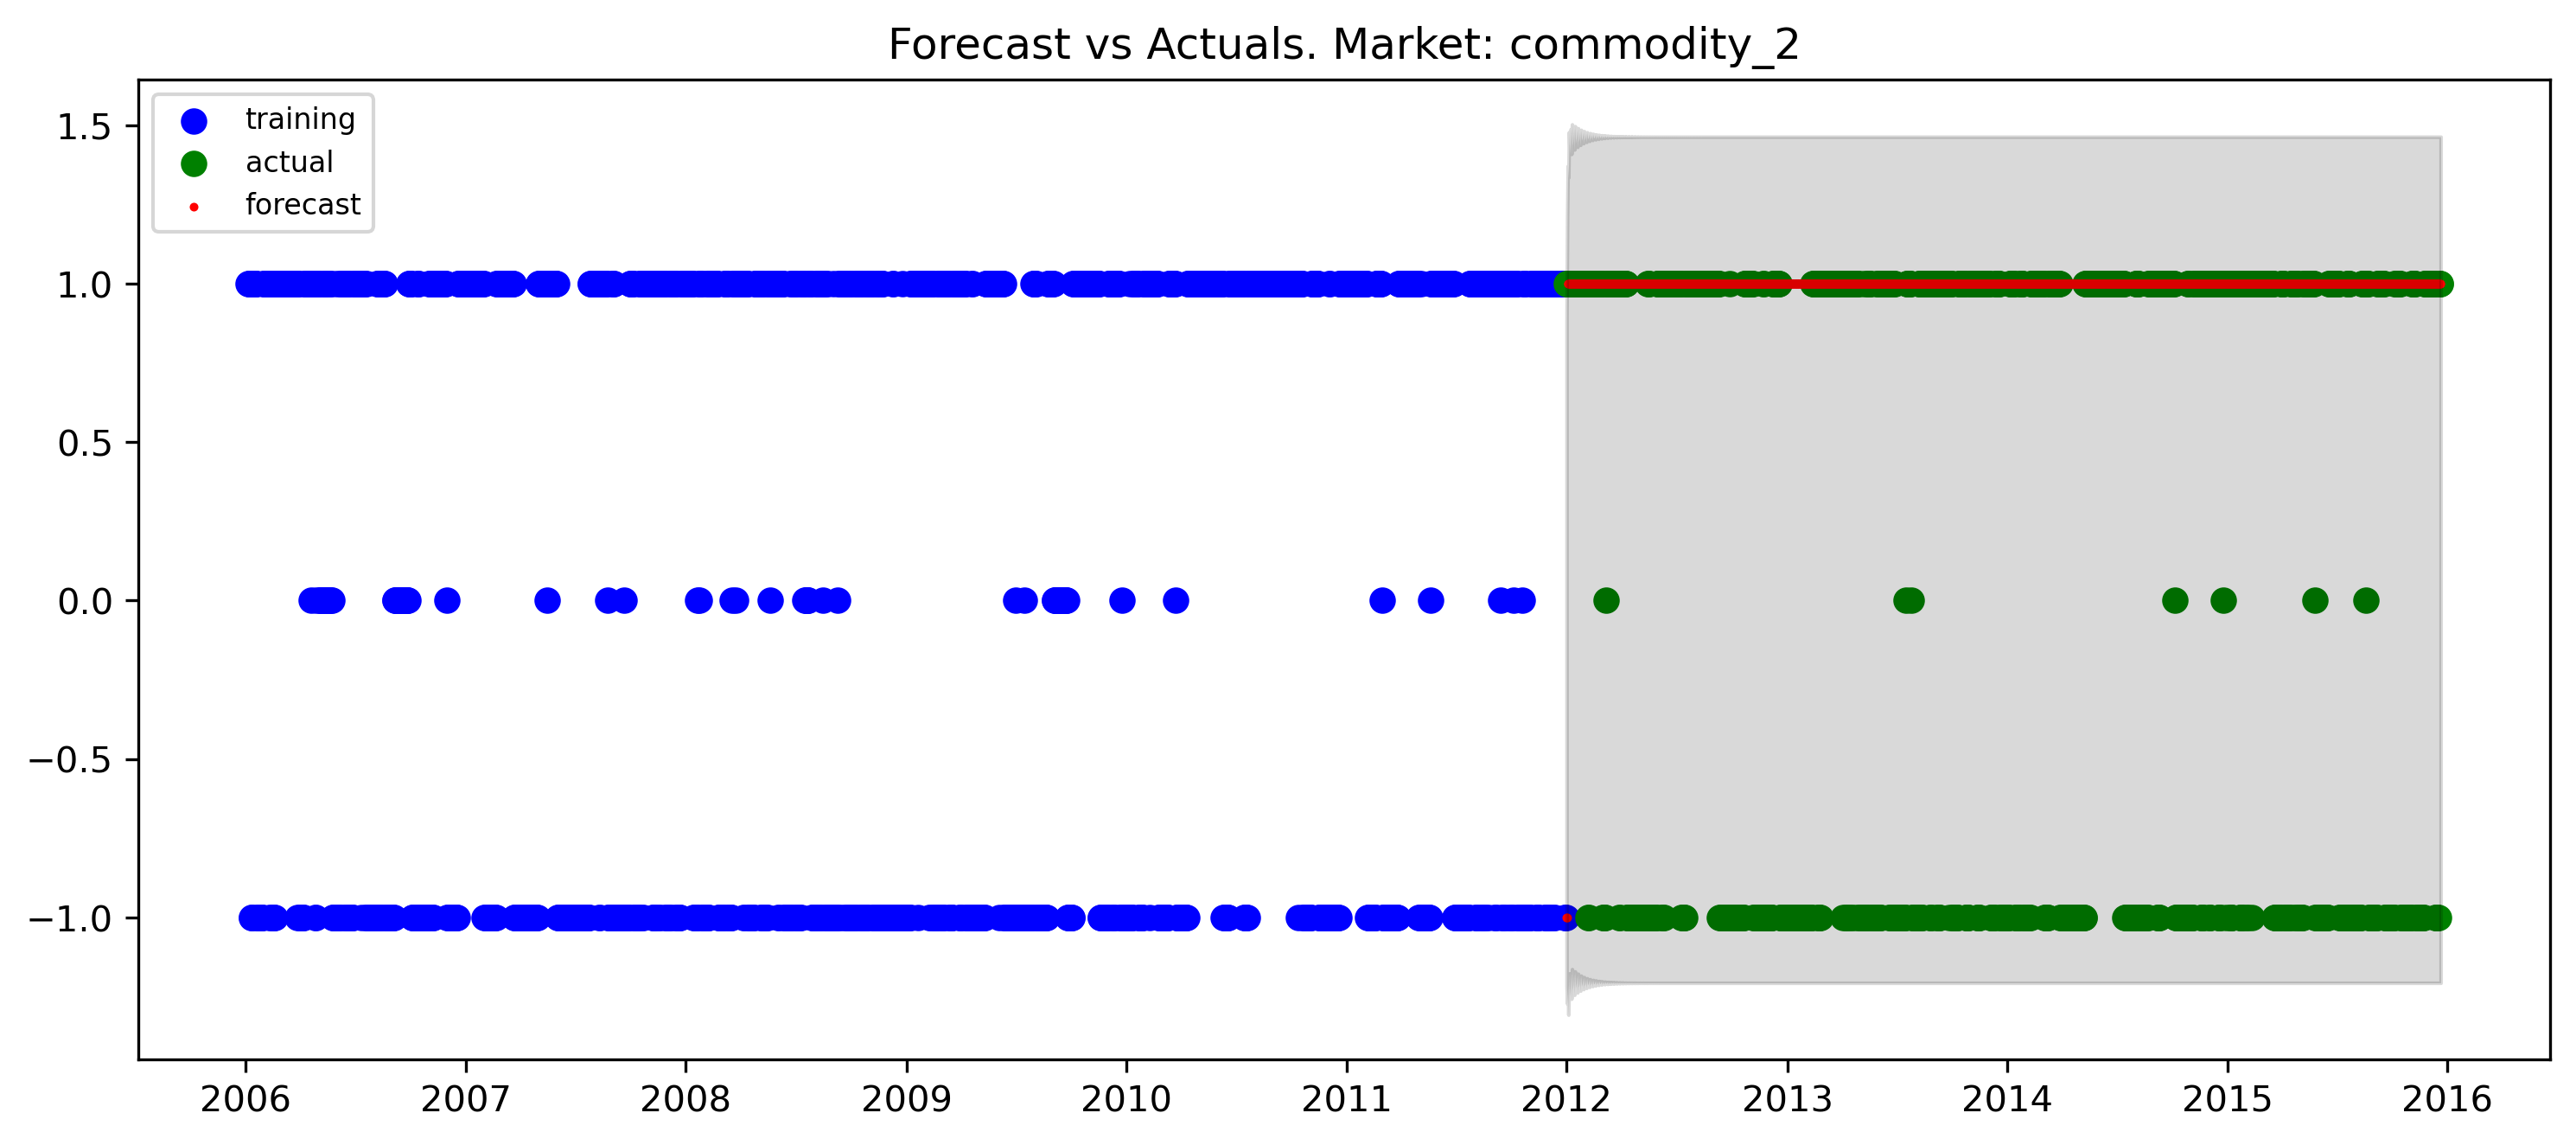

currency_2
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2186
Model:                     ARMA(5, 2)   Log Likelihood               -2178.031
Method:                       css-mle   S.D. of innovations              0.655
Date:                Sun, 28 Mar 2021   AIC                           4374.062
Time:                        14:10:12   BIC                           4425.271
Sample:                    01-06-2006   HQIC                          4392.781
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0012      0.040      0.032      0.975      -0.076       0.079
ar.L1.return     0.2970      0.135      2.207      0.027       0.033       0.561
ar.L2.return    -0.2034      0.12

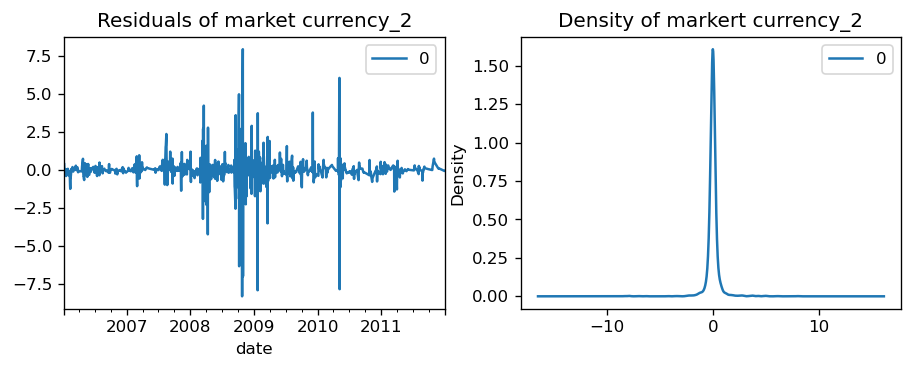

'Accuracy of ARIMA market currency_2: 0.5649171270718232'


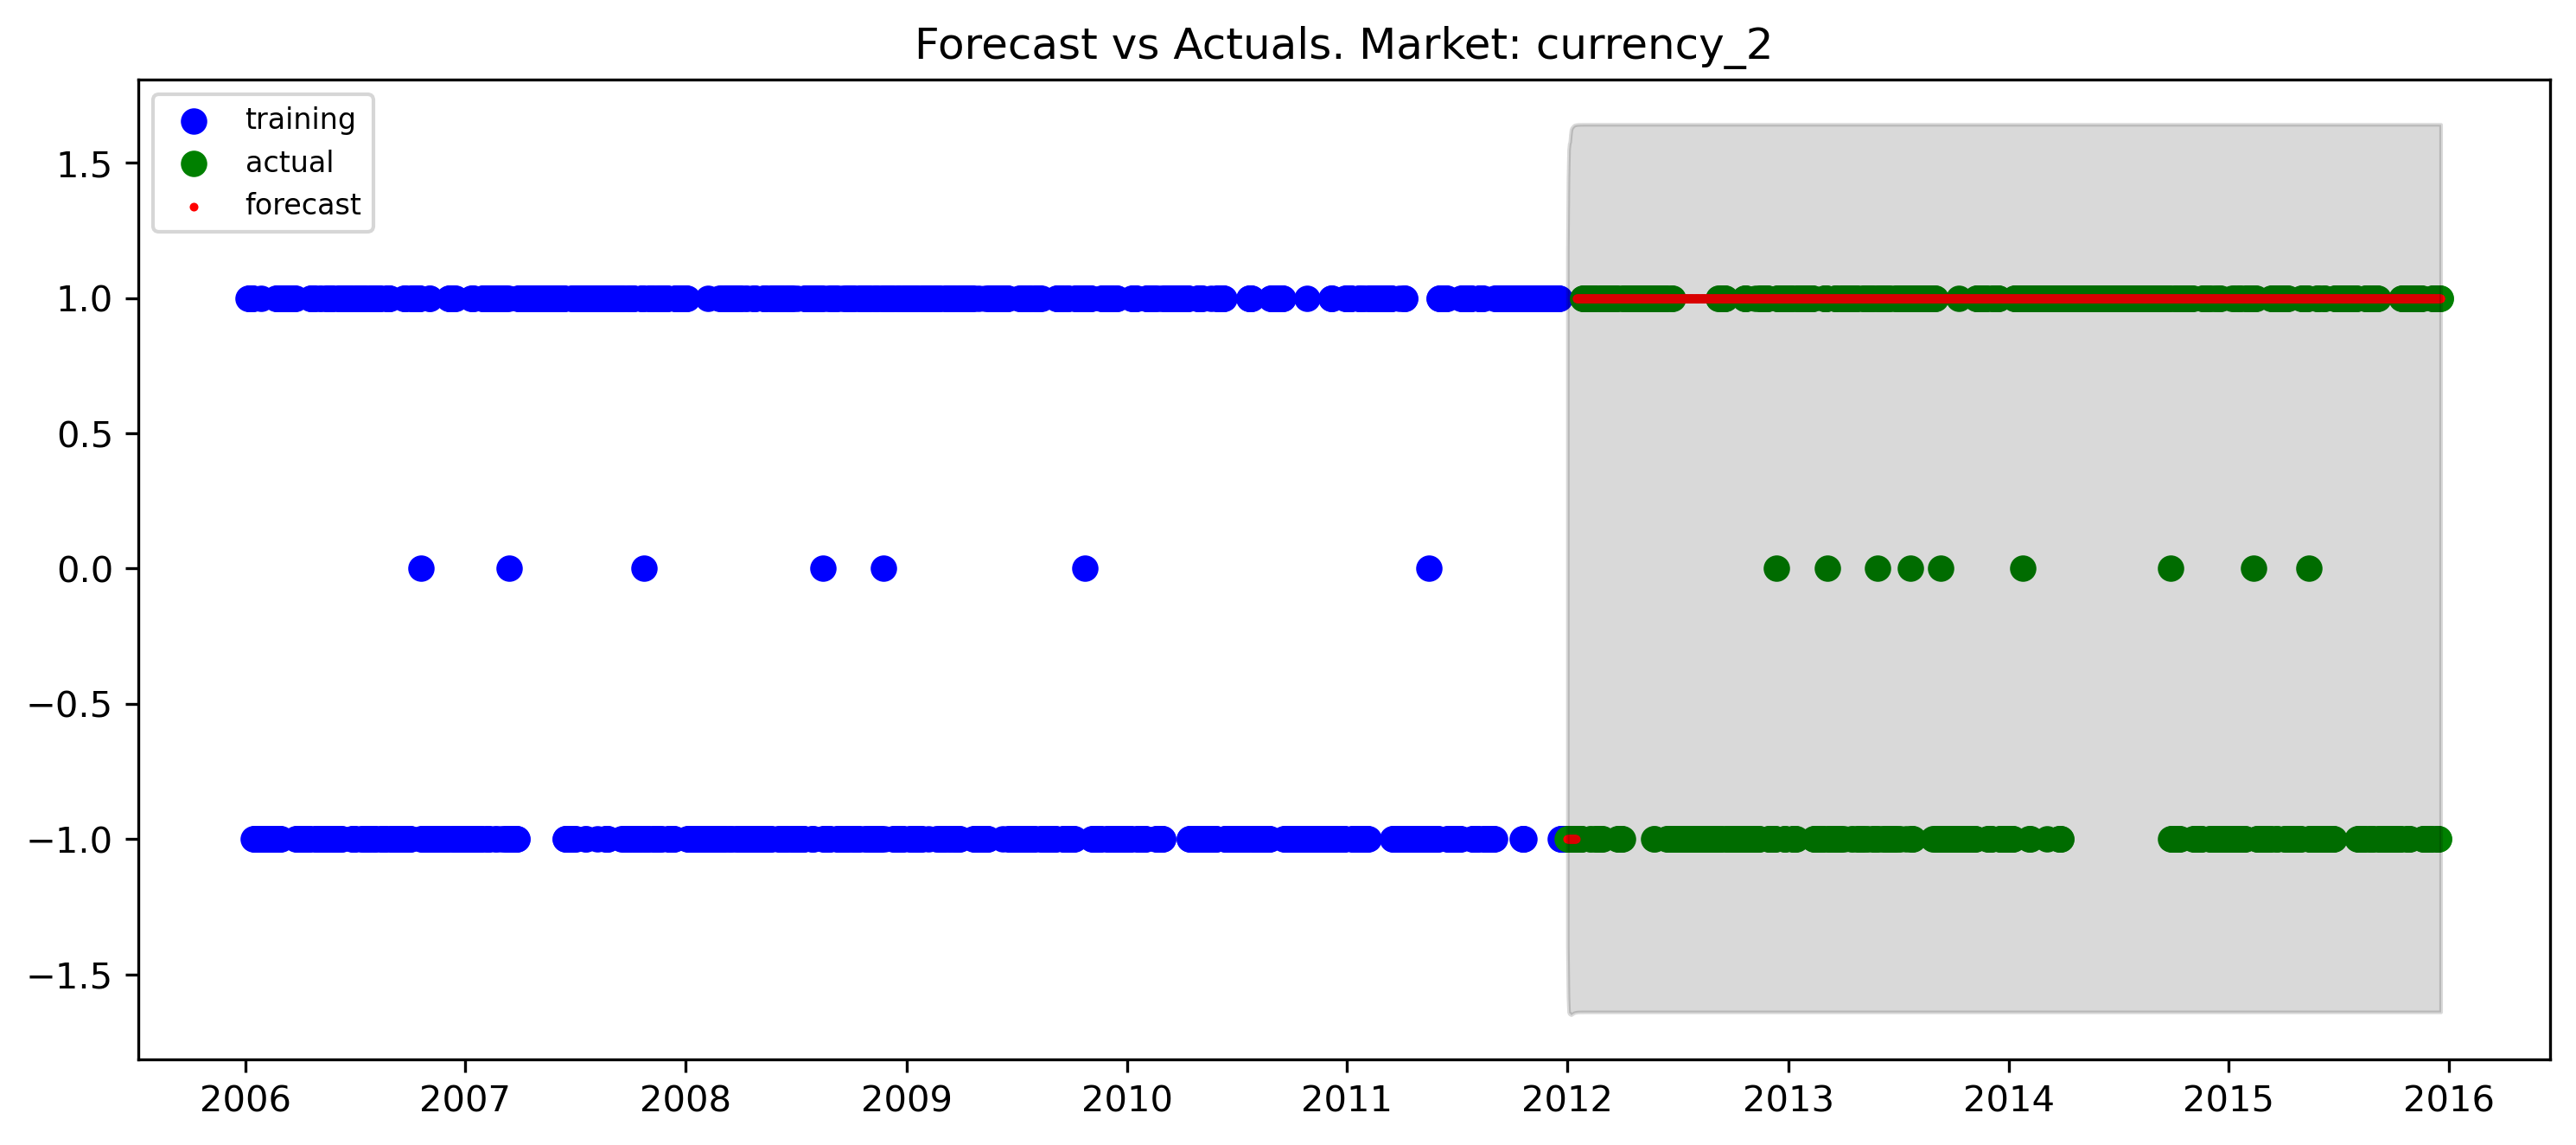

commodity_1
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2186
Model:                     ARMA(5, 2)   Log Likelihood               -1952.277
Method:                       css-mle   S.D. of innovations              0.591
Date:                Sun, 28 Mar 2021   AIC                           3922.554
Time:                        14:10:13   BIC                           3973.762
Sample:                    01-06-2006   HQIC                          3941.272
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1331      0.046      2.893      0.004       0.043       0.223
ar.L1.return     0.4524      0.297      1.523      0.128      -0.130       1.035
ar.L2.return     0.4749      0.2

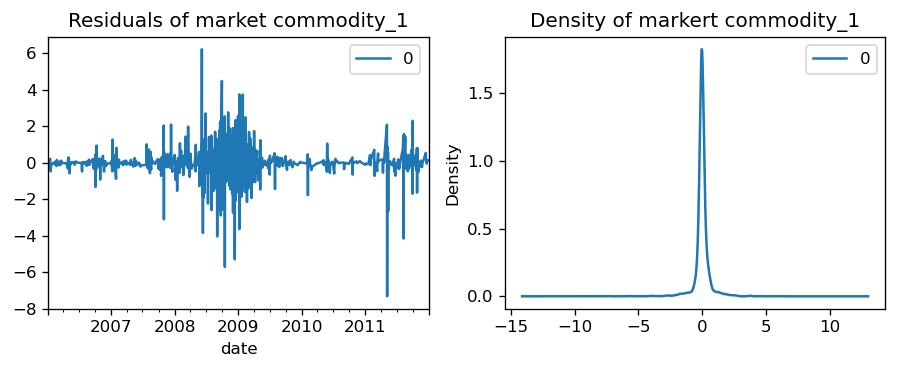

'Accuracy of ARIMA market commodity_1: 0.5489390828199863'


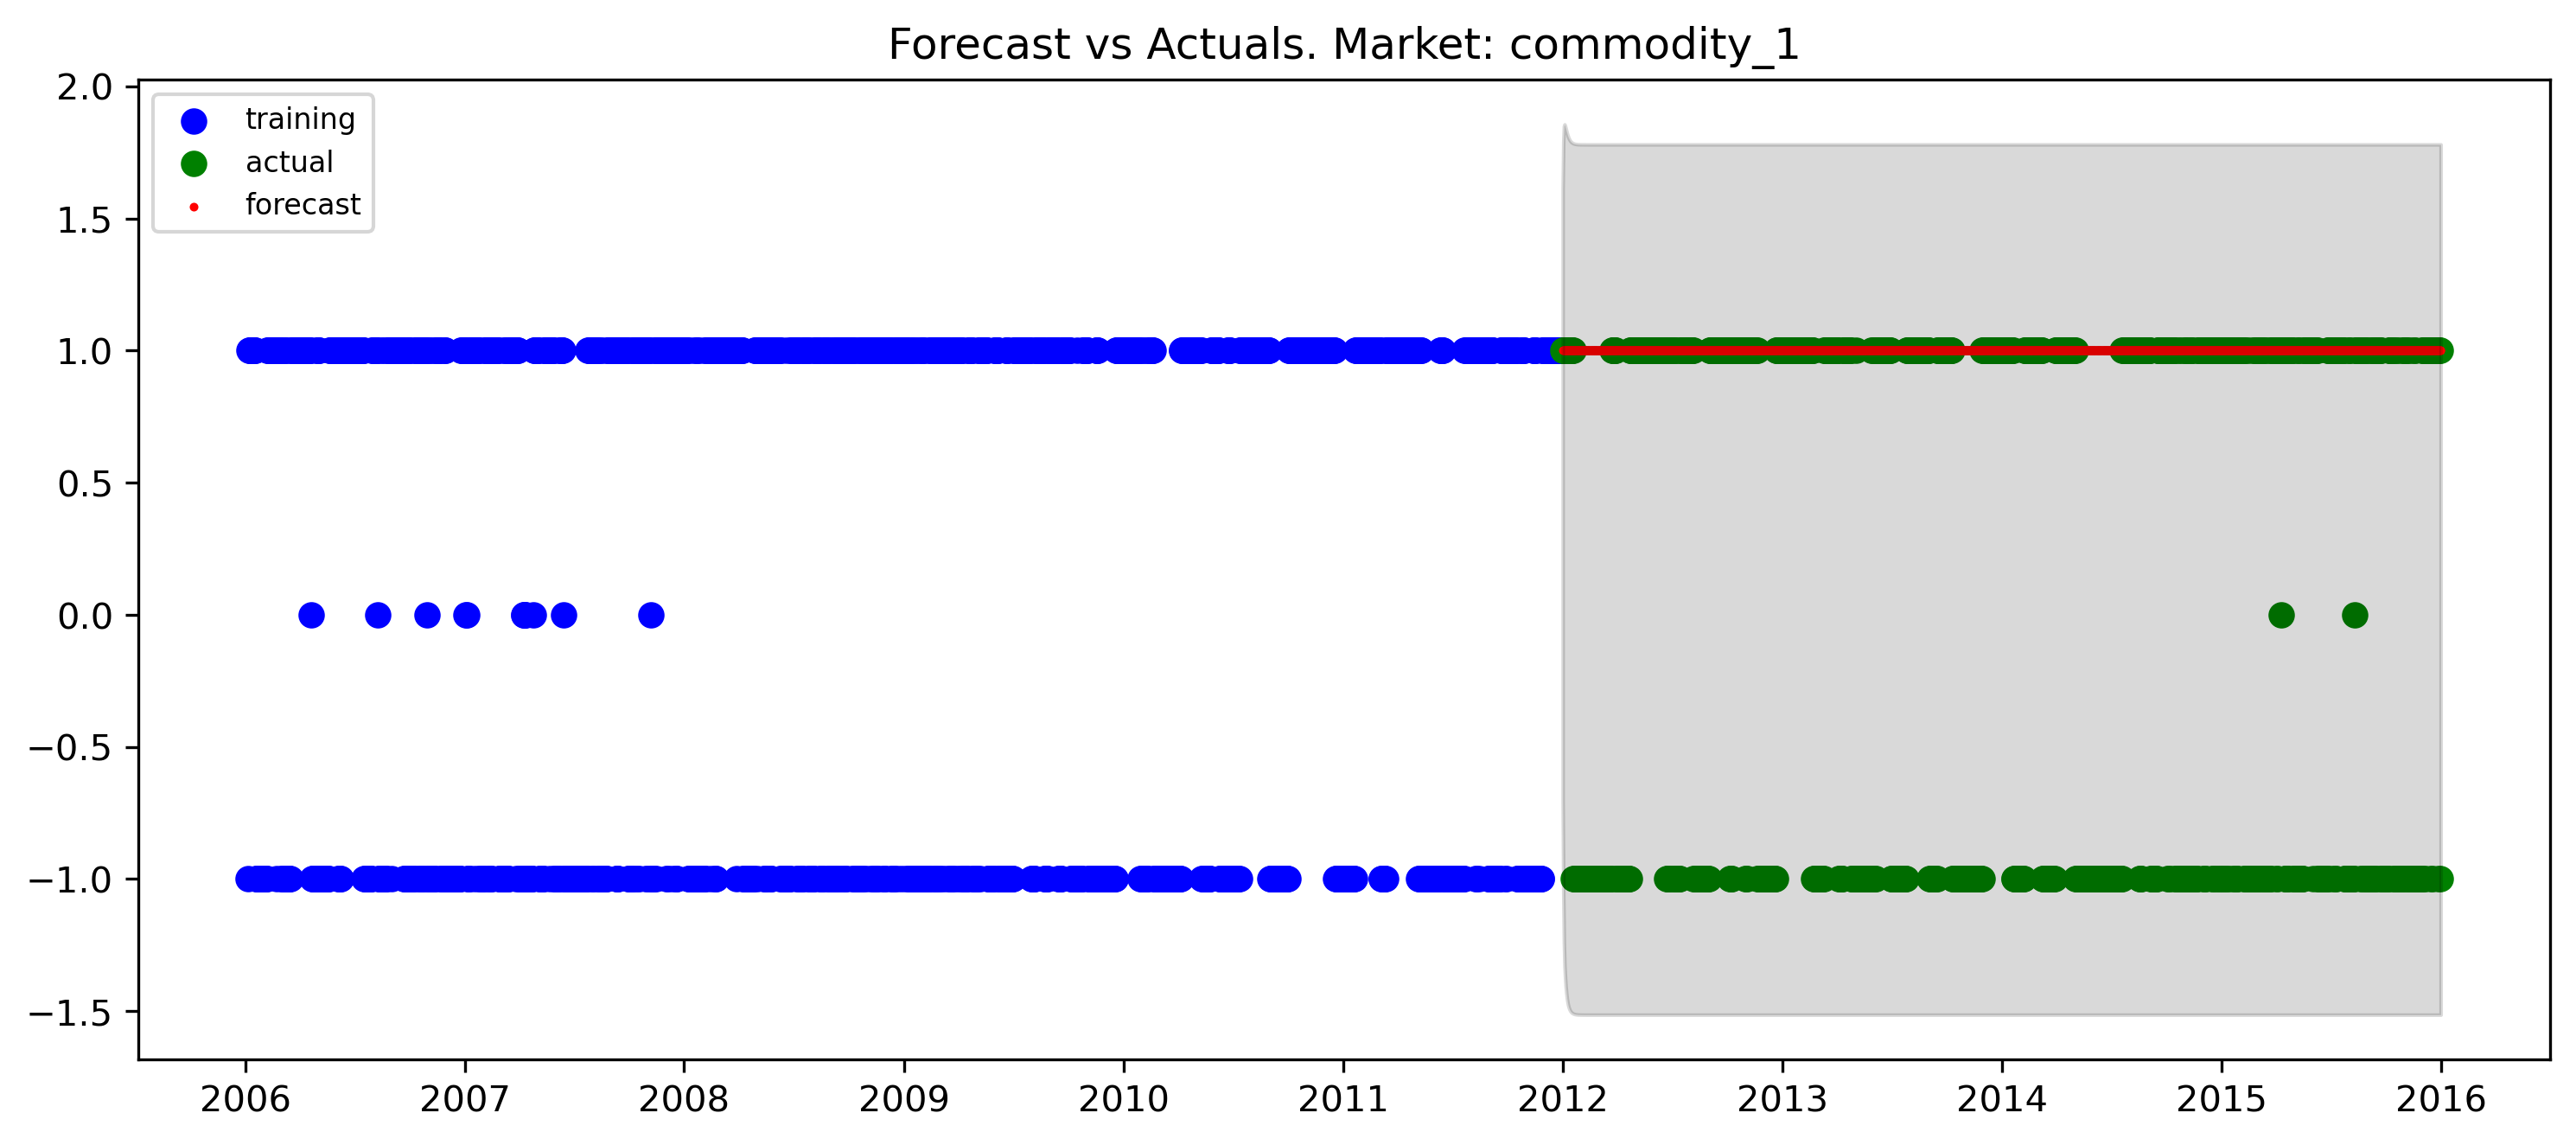

bond_2
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2182
Model:                     ARMA(5, 2)   Log Likelihood               -2021.789
Method:                       css-mle   S.D. of innovations              0.611
Date:                Sun, 28 Mar 2021   AIC                           4061.579
Time:                        14:10:16   BIC                           4112.771
Sample:                    01-10-2006   HQIC                          4080.292
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1008      0.033      3.026      0.002       0.036       0.166
ar.L1.return    -0.7526      0.034    -21.839      0.000      -0.820      -0.685
ar.L2.return    -0.0994      0.059   

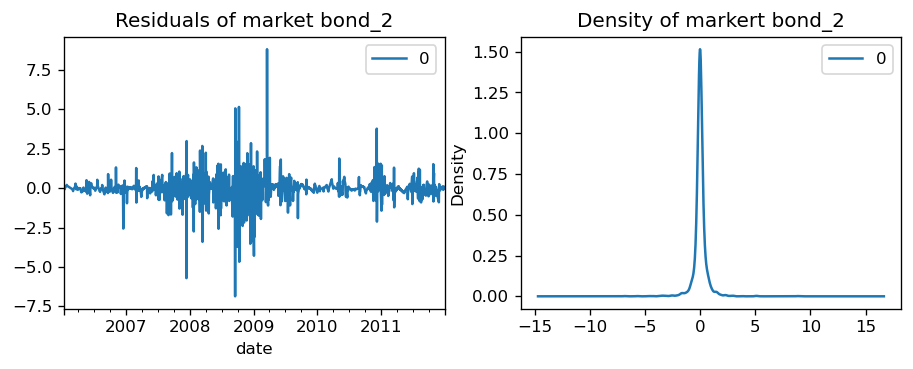

'Accuracy of ARIMA market bond_2: 0.5250171350239891'


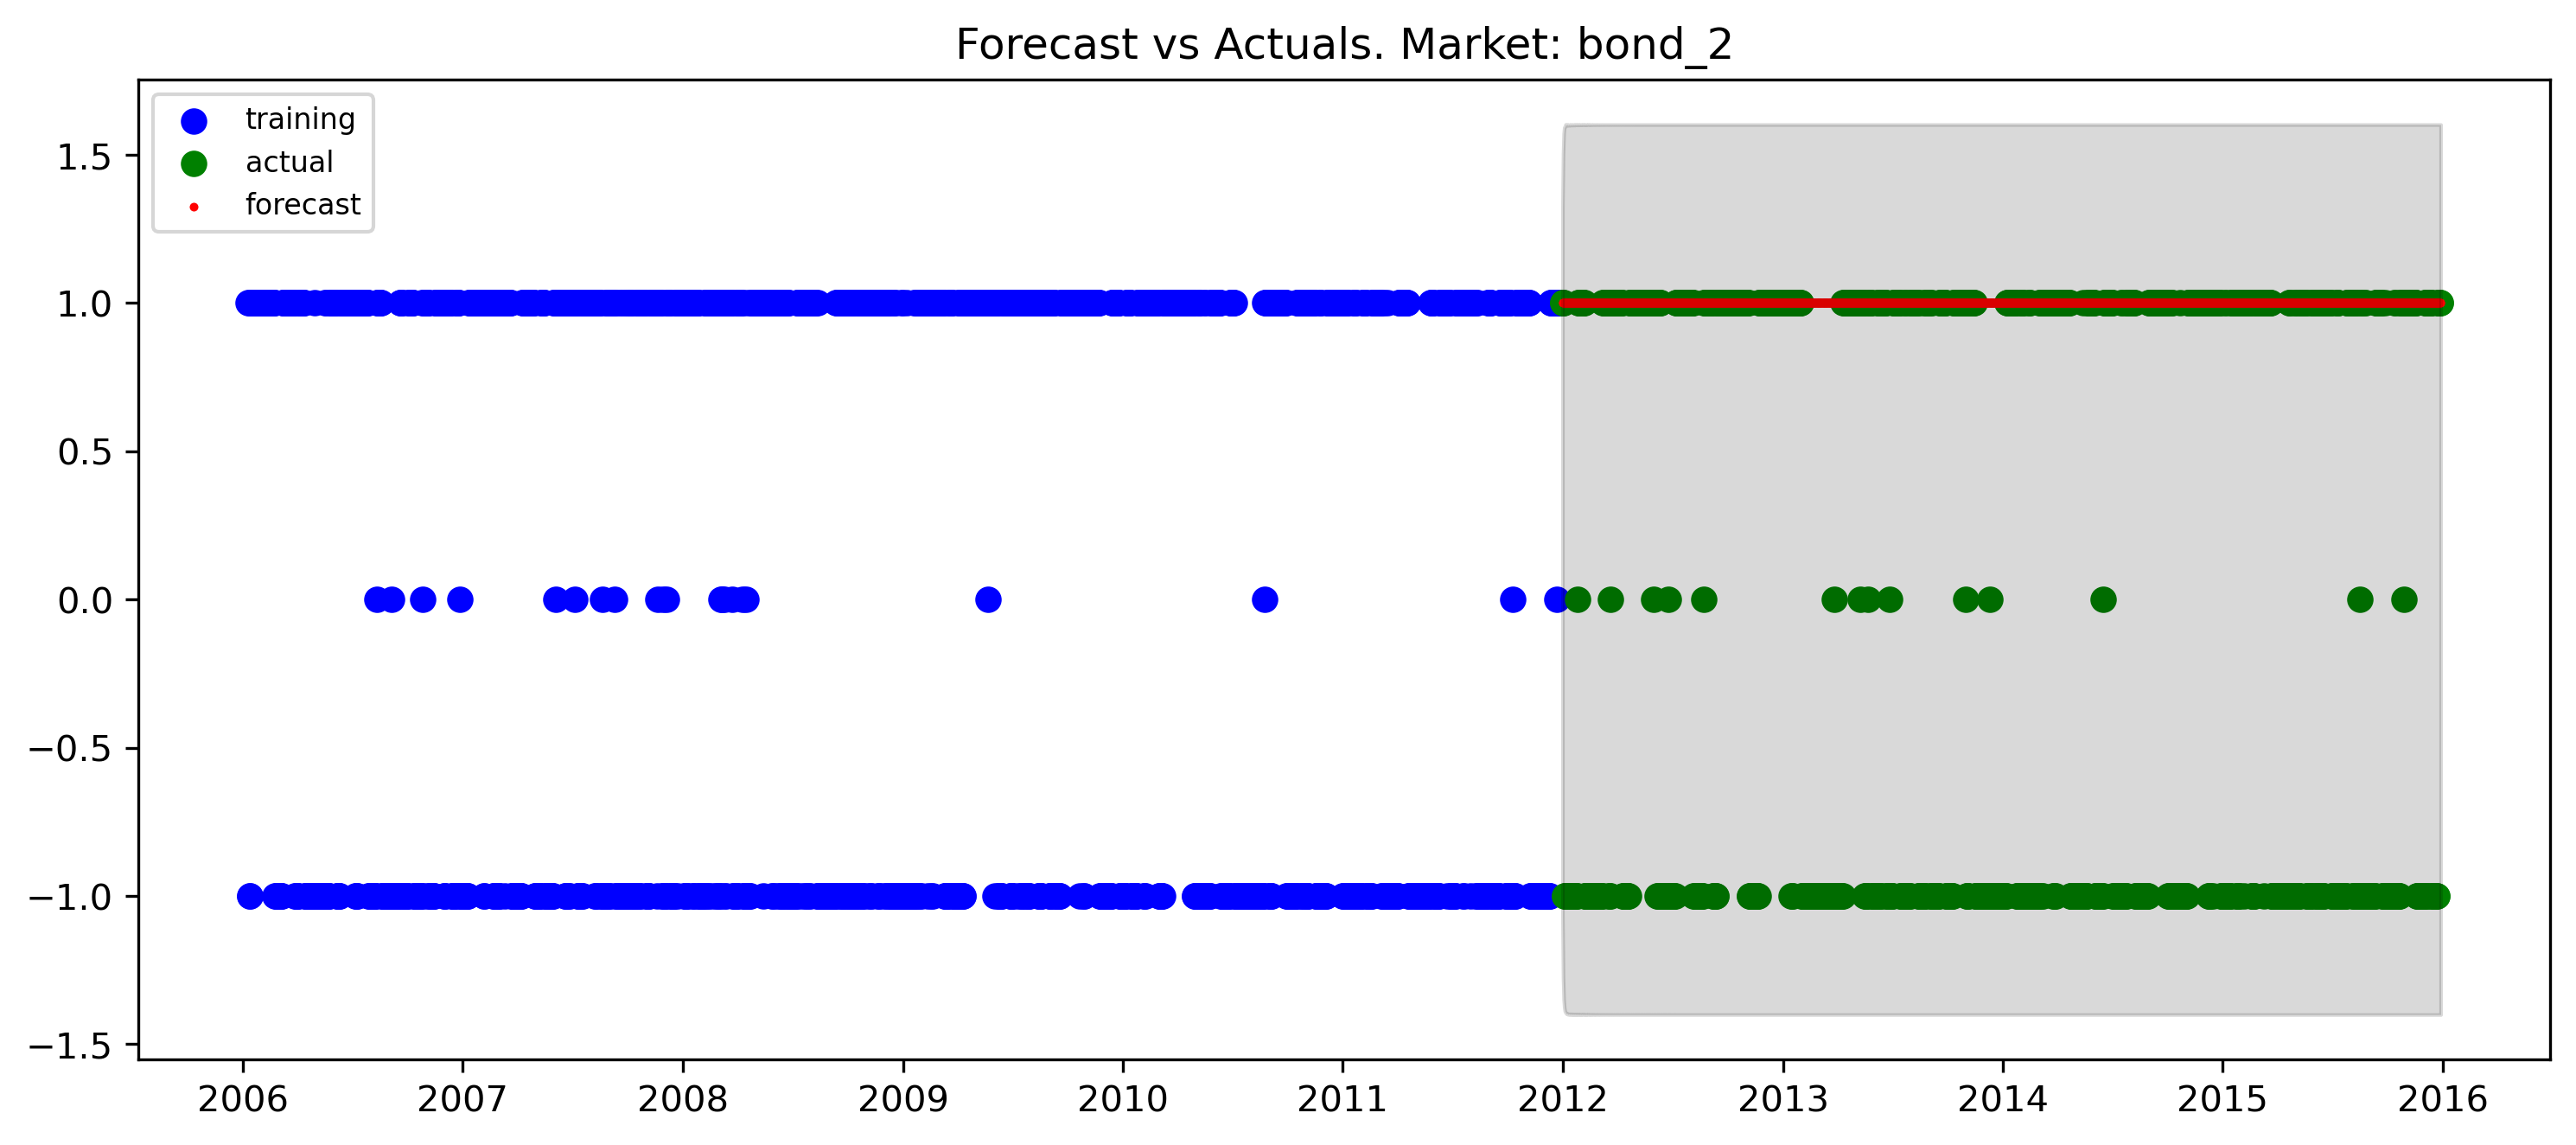

stock_2
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 2172
Model:                     ARMA(5, 2)   Log Likelihood                -455.052
Method:                       css-mle   S.D. of innovations              0.298
Date:                Sun, 28 Mar 2021   AIC                            928.103
Time:                        14:10:19   BIC                            979.254
Sample:                    01-20-2006   HQIC                           946.807
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0532      0.017      3.119      0.002       0.020       0.087
ar.L1.return     0.0680      0.067      1.019      0.308      -0.063       0.199
ar.L2.return     0.8268      0.043  

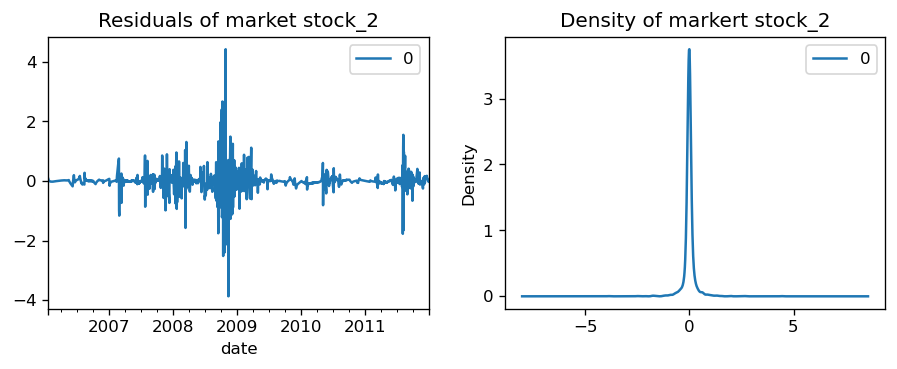

'Accuracy of ARIMA market stock_2: 0.6127484578478409'


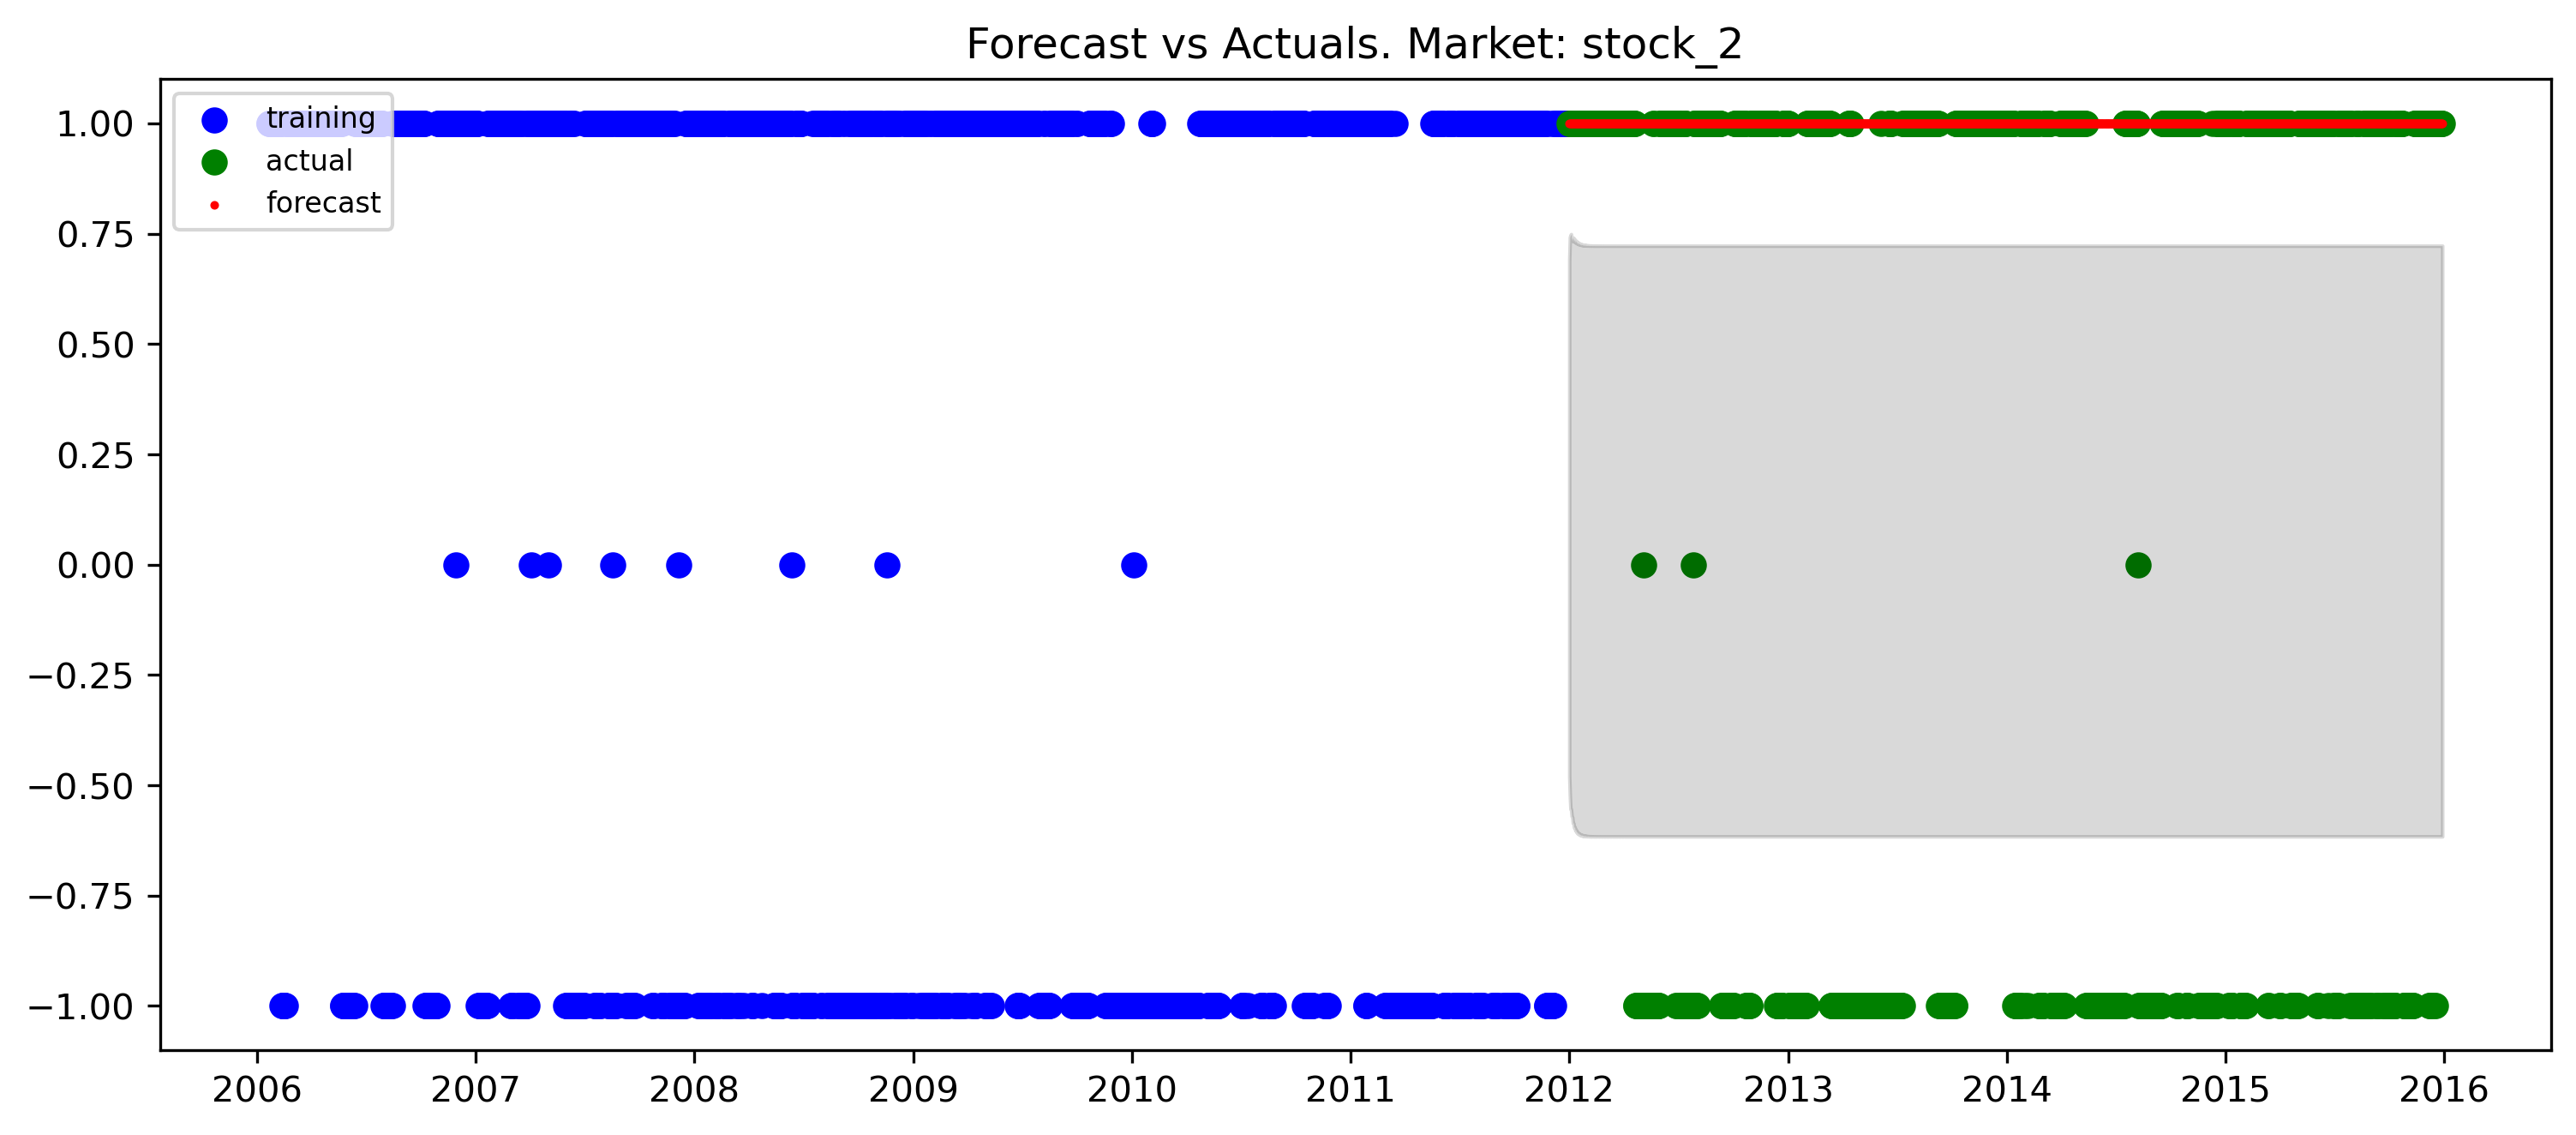

stock_1
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                  719
Model:                     ARMA(5, 2)   Log Likelihood                -572.529
Method:                       css-mle   S.D. of innovations              0.536
Date:                Sun, 28 Mar 2021   AIC                           1163.058
Time:                        14:10:21   BIC                           1204.259
Sample:                    01-12-2010   HQIC                          1178.965
                         - 12-31-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1498      0.048      3.094      0.002       0.055       0.245
ar.L1.return     0.0706      0.306      0.231      0.818      -0.529       0.670
ar.L2.return    -0.3131      0.138  

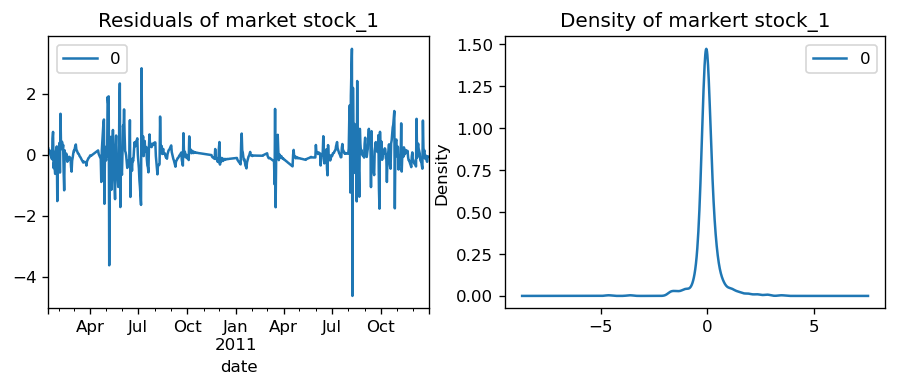

'Accuracy of ARIMA market stock_1: 0.5633995887594243'


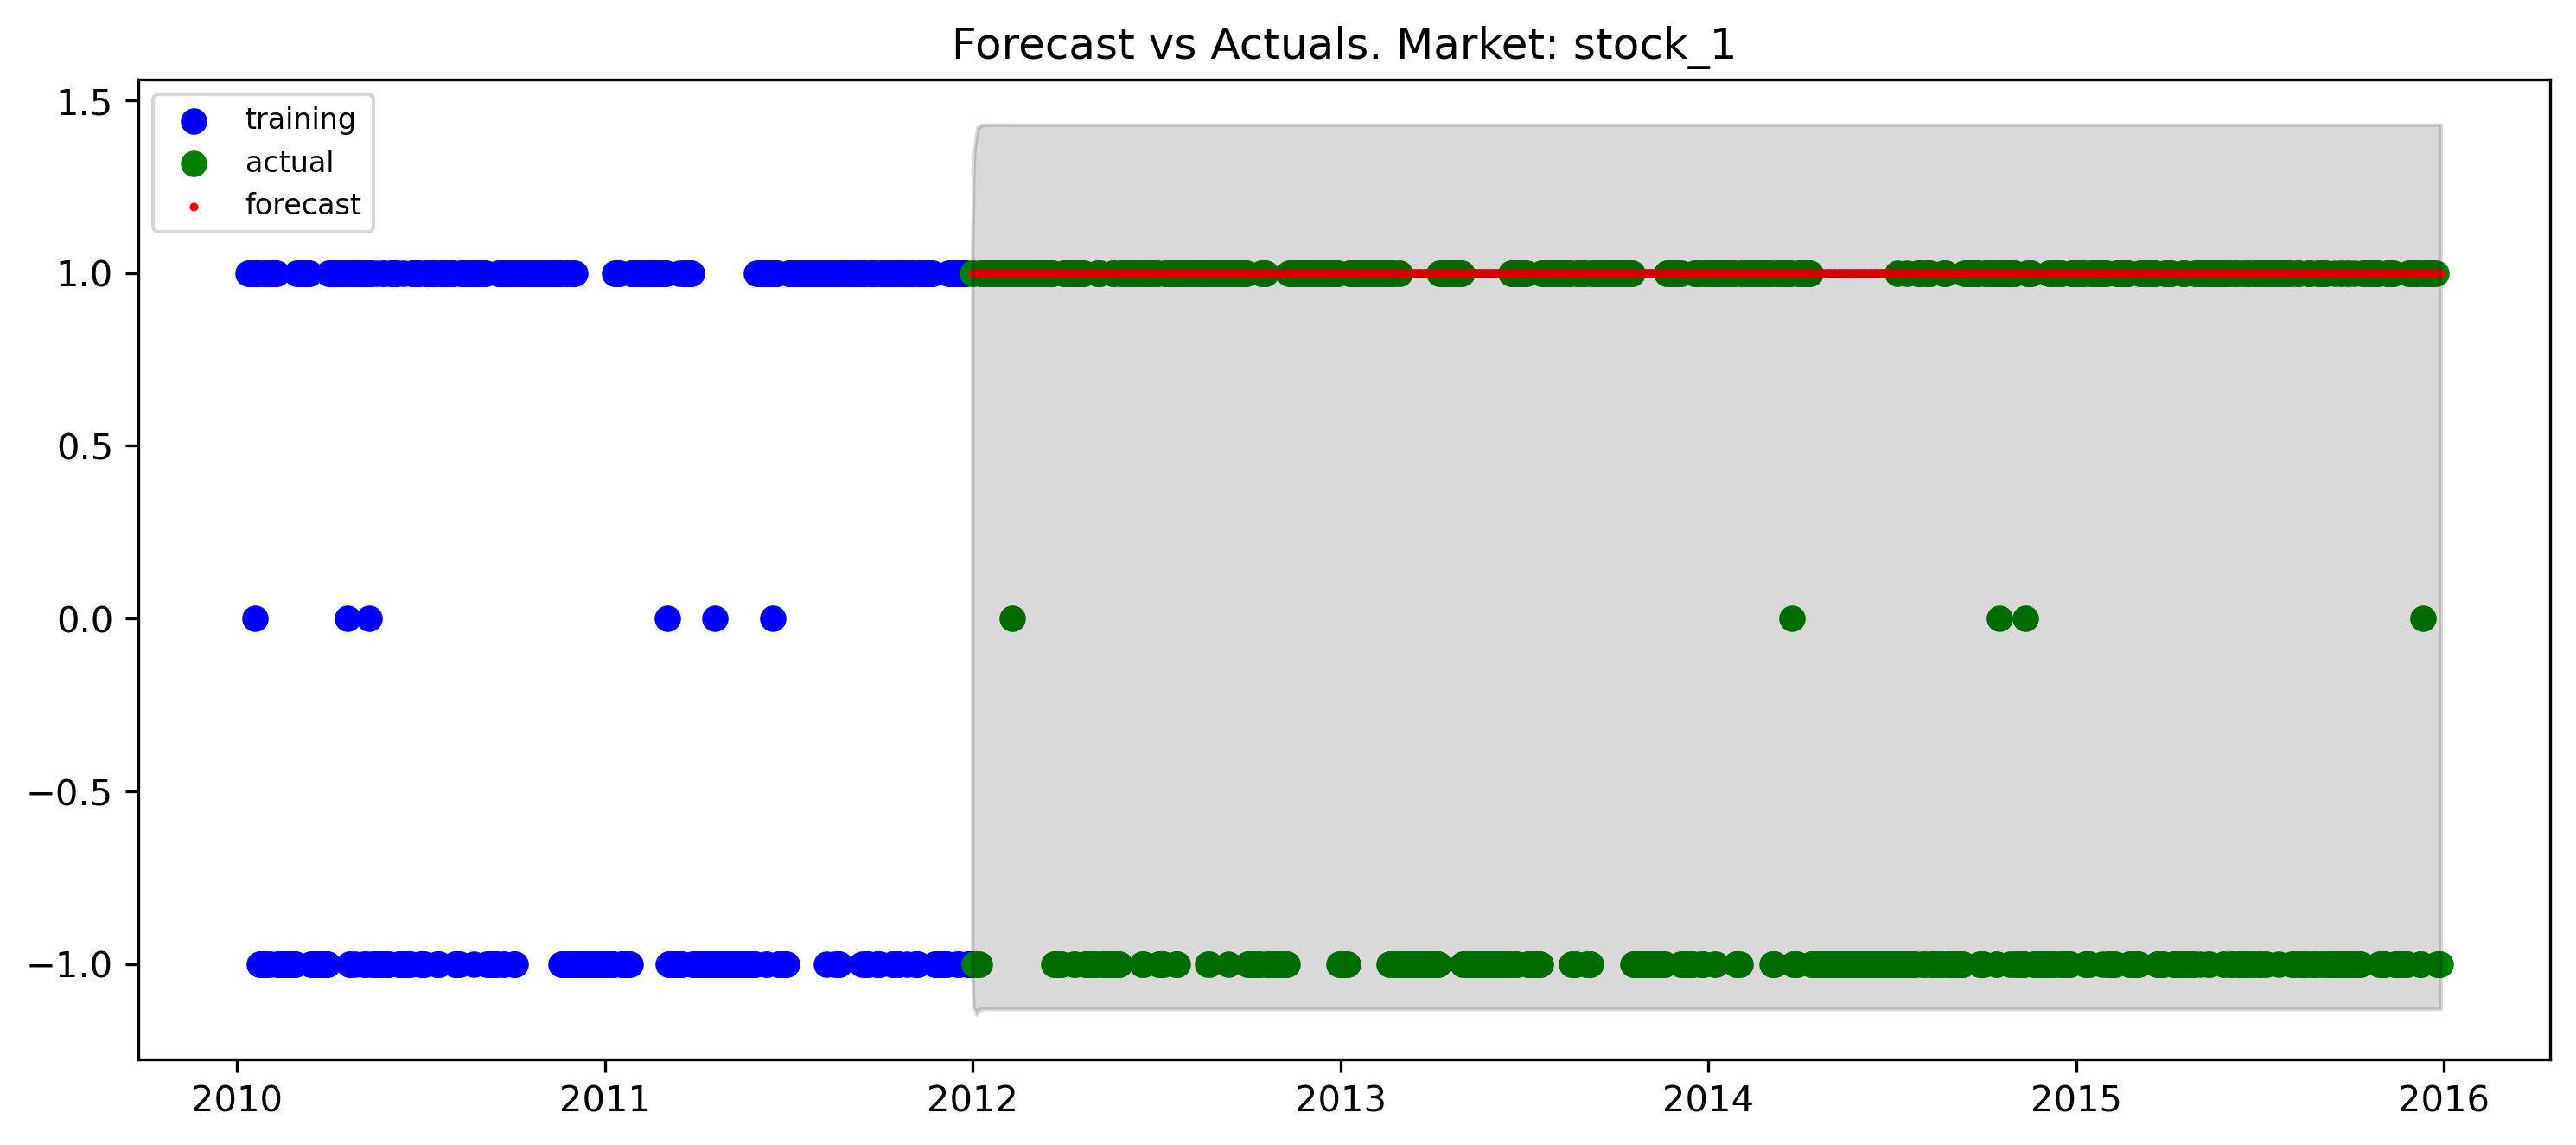

In [15]:
# ARIMA Model
for market in df_train['market'].unique():
    df_train_market = df_train[df_train['market'] == market]
    df_train_market['date_index'] = df_train_market.index
    df_test_market = df_test[df_test['market'] == market]
    df_test_market['date_index'] = df_test_market.index
    model = ARIMA(df_train_market['return'], order=(5,0,2))
    model_fit = model.fit(disp=0)
    print(market)
    print(model_fit.summary())
    

    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals of market "+ market, ax=ax[0])
    residuals.plot(kind='kde', title='Density of markert ' + market, ax=ax[1])
    plt.show()
    
    
    # Actual vs fitted
    n = len(df_test_market['return'])

    fc, se, conf = model_fit.forecast(n, alpha=0.05)

    fc_series = pd.Series(fc, index=df_test_market['return'].index)
    lower_series = pd.Series(conf[:, 0], index=df_test_market['return'].index)
    upper_series = pd.Series(conf[:, 1], index=df_test_market['return'].index)

    label_pred = fc_series.apply(lambda l: -1 if l < 0 else (1 if l > 0 else 0))

    # Accuracy
    accuracy = sum(label_pred == df_test_market['label'].values) / len(df_test_market['label'])
    pp('Accuracy of ARIMA market ' + market + ': ' + str(accuracy))
    
    plt.figure(figsize=(12,5), dpi=300)
    plt.scatter(df_train_market.index, df_train_market['label'], label='training', c='b', s=40)
    plt.scatter(df_test_market['date_index'], df_test_market['label'], label='actual', s=40, c='g')
    plt.scatter(df_test_market['date_index'], label_pred, label='forecast', s=2, c='r')
    plt.fill_between(df_test_market['date_index'], lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals. Market: ' + market)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    

## Conclusion

The ARIMA model build performance highly depends on the market to be studied, ranging from 0.4 to 0.7. This suggests that this model is not highly robust and more trials should be done. Tuning of parameter p was done, yet similar unsatisfactory results were obtained. 